In [ ]:
# Imports.
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from distseal.loader import load_watermarker
import torch
import distseal.augmentation.neuralcompression as neuralcompression

EfficientViT not found.


/home/sylvestre/miniconda3/envs/distseal/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CompressAI package not found. Install with pip install compressai
Taming Transformers not found. Install for VQGAN support


/home/sylvestre/miniconda3/envs/distseal/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


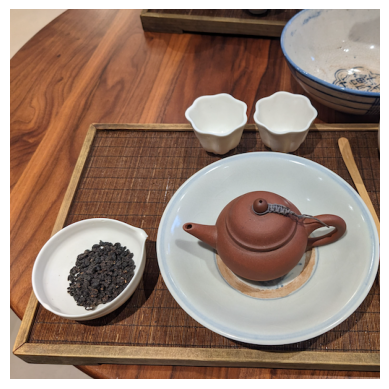

In [2]:
# Load an image.
res = 512
img = Image.open('assets/low_res_tea_pot.png').resize((res, res)).convert('RGB')
plt.imshow(img)
plt.axis('off')
plt.show()

# Convert PIL image to torch tensor.
transform = transforms.Compose([
    transforms.ToTensor()
])
img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

In [7]:
torch.set_grad_enabled(False)
device = torch.device("cuda")

# Load DC-AE post-hoc watermarker.
watermarker_yaml = "detector_dc-ae.yaml"
watermarker, _, scaling_w = load_watermarker(watermarker_yaml, device=device)
watermarker.blender.scaling_w = scaling_w
watermarker.img_size = res

# Load DC-AE autoencoder.
autoencoder_name = "DCAEf64c128"
autoencoder = getattr(neuralcompression, autoencoder_name)()
autoencoder = autoencoder.to(device)

# Original autoencoder reconstruction.
img_tensor = img_tensor.to(device)
latent_samples, ori_size = autoencoder.encode_pre_quant(img_tensor)
image_ae_ori = autoencoder.decode(latent_samples, ori_size).clamp(0.0, 1.0)

# Post-hoc latent watermarking.
msg = watermarker.get_random_msg()
msg = msg.repeat(latent_samples.shape[0], 1)
preds_w = watermarker.embedder(latent_samples, msg.to(device))
latent_w = watermarker.blender(latent_samples, preds_w)
image_wm = autoencoder.decode(latent_w, ori_size).clamp(0.0, 1.0)

File /storage/home/sylvestre/tmp/avseal/checkpoints/distseal/detector_dcae_diffusion.pt exists, skipping download


File /storage/home/sylvestre/tmp/avseal/checkpoints/distseal/detector_dcae_diffusion_msg.npy exists, skipping download


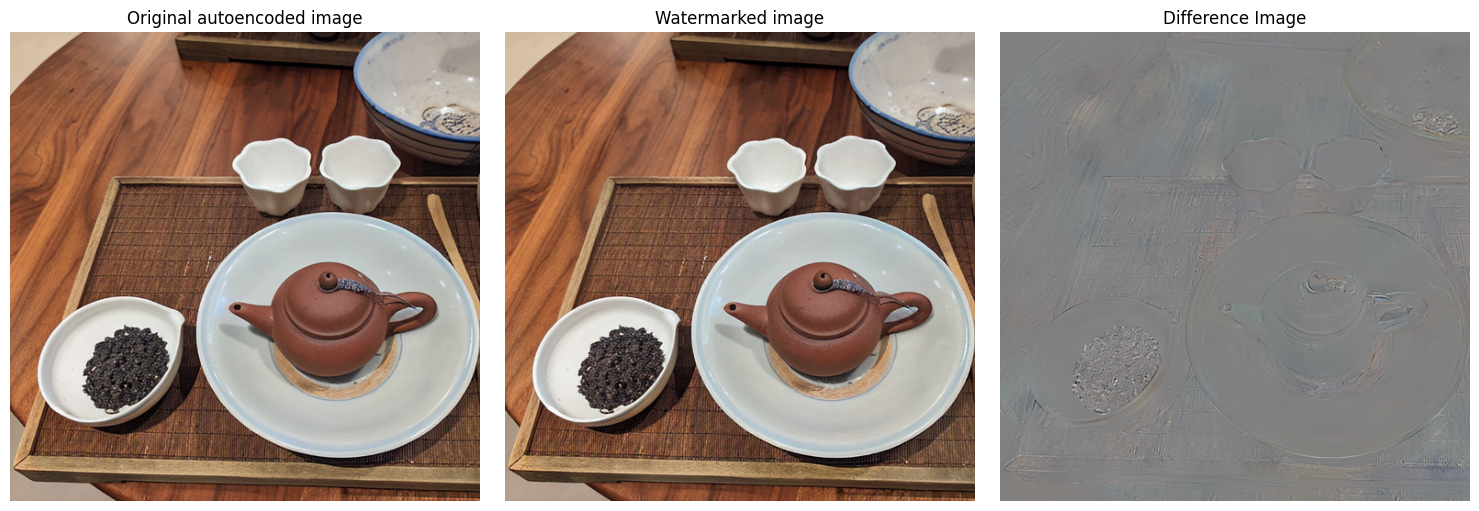

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original autoencoded image.
axes[0].imshow(image_ae_ori[0].cpu().permute(1, 2, 0).numpy())
axes[0].set_title('Original autoencoded image')
axes[0].axis('off')

# Watermarked image.
axes[1].imshow(image_wm[0].cpu().permute(1, 2, 0).numpy())
axes[1].set_title('Watermarked image')
axes[1].axis('off')

# Diff image.
diff_signed = image_wm[0] - image_ae_ori[0]
diff_vis = (diff_signed - diff_signed.min()) / (diff_signed.max() - diff_signed.min())
axes[2].imshow(diff_vis.cpu().permute(1, 2, 0).numpy())
axes[2].set_title('Difference Image')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [9]:
# Checking the bit accuracy.
from distseal.utils.metrics import message_accuracy
msg_pred = watermarker.detector.detect_watermark(image_wm)
bit_acc = message_accuracy(msg, msg_pred)
print(f"Bit accuracy: {bit_acc * 100:.2f}%")

Bit accuracy: 100.00%
